In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import io
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report

In [3]:
with open('/content/drive/MyDrive/gene_attribute_matrix.txt', 'r', encoding='latin-1') as f:
  data = f.readlines()

In [4]:
data_start_idx = None
for i, line in enumerate(data):
    if line.startswith('!series_matrix_table_begin'):
        data_start_idx = i + 1
        break

data_end_idx = None
for i, line in enumerate(data):
    if line.startswith('!series_matrix_table_end'):
        data_end_idx = i
        break

matrix_lines = data[data_start_idx:data_end_idx]
matrix_data = ''.join(matrix_lines)
df = pd.read_csv(io.StringIO(matrix_data), sep='\t', index_col=0)

In [5]:
mastocytosis_terms = ['mastocytosis', 'mast cell', 'systemic mastocytosis']

for term in mastocytosis_terms:
    matches = [col for col in df.columns if term.lower() in col.lower()]
    if matches:
        print(f"'{term}': {matches}")
    else:
        print(f"'{term}': No matches found")

'mastocytosis': ['diffuse cutaneous mastocytosis', 'aggressive systemic mastocytosis', 'mastocytosis', 'cutaneous mastocytosis', 'systemic mastocytosis', 'indolent systemic mastocytosis']
'mast cell': ['mast cell neoplasm']
'systemic mastocytosis': ['aggressive systemic mastocytosis', 'systemic mastocytosis', 'indolent systemic mastocytosis']


In [6]:
print("\nUnique values in 'Disease' column:")
print(df['Disease'].value_counts())


Unique values in 'Disease' column:
Disease
7008         1
DOID         1
GeneID/NA    1
80059        1
22847        1
            ..
9721         1
29035        1
145858       1
460          1
129684       1
Name: count, Length: 15311, dtype: int64


In [7]:
mastocytosis_columns = [
    'systemic mastocytosis',
    'indolent systemic mastocytosis',
    'aggressive systemic mastocytosis',
    'cutaneous mastocytosis',
    'diffuse cutaneous mastocytosis',
    'mastocytosis',
    'mast cell neoplasm'
]

In [8]:
mastocytosis_data = df[mastocytosis_columns]
print("Mastocytosis data shape:", mastocytosis_data.shape)
print("\nMastocytosis data summary:")
print(mastocytosis_data.describe())

Mastocytosis data shape: (15311, 7)

Mastocytosis data summary:
        systemic mastocytosis  indolent systemic mastocytosis  \
count                 15311.0                         15311.0   
unique                    5.0                             5.0   
top                       0.0                             0.0   
freq                  15015.0                         15126.0   

        aggressive systemic mastocytosis  cutaneous mastocytosis  \
count                            15311.0                 15311.0   
unique                               5.0                     5.0   
top                                  0.0                     0.0   
freq                             15128.0                 15003.0   

        diffuse cutaneous mastocytosis  mastocytosis  mast cell neoplasm  
count                          15311.0       15311.0             15311.0  
unique                             5.0           5.0                 5.0  
top                                0.0      

In [9]:
print("\nNon-zero values per mastocytosis type:")
for col in mastocytosis_columns:
    non_zero_count = (df[col] != 0).sum()
    print(f"{col}: {non_zero_count} non-zero values")


Non-zero values per mastocytosis type:
systemic mastocytosis: 296 non-zero values
indolent systemic mastocytosis: 185 non-zero values
aggressive systemic mastocytosis: 183 non-zero values
cutaneous mastocytosis: 308 non-zero values
diffuse cutaneous mastocytosis: 134 non-zero values
mastocytosis: 485 non-zero values
mast cell neoplasm: 298 non-zero values


In [10]:
def clean_data(df):
    metadata_cols = ['#.1', 'Disease']
    data_cols = [col for col in df.columns if col not in metadata_cols]
    df_clean = df.copy()
    for col in data_cols:
        df_clean[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    print(f"Data cleaning complete. Shape: {df_clean.shape}")
    return df_clean

df_clean = clean_data(df)

Data cleaning complete. Shape: (15311, 4630)


In [11]:
def extract_mastocytosis_genes(df, threshold=0.0):
    mastocytosis_genes = df[df[mastocytosis_columns].abs().max(axis=1) > threshold]

    print(f"Found {len(mastocytosis_genes)} genes associated with mastocytosis")
    return mastocytosis_genes, mastocytosis_columns

In [12]:
def prepare_classification_data(df):
    mastocytosis_mask = df[mastocytosis_columns].abs().max(axis=1) > 0
    mastocytosis_genes = df[mastocytosis_mask].copy()

    print(f"Found {len(mastocytosis_genes)} genes associated with mastocytosis")

    y_binary = (mastocytosis_genes[mastocytosis_columns].abs().max(axis=1) > 0).astype(int)


    y_multiclass = mastocytosis_genes[mastocytosis_columns].abs().idxmax(axis=1)

    feature_columns = [col for col in df.columns if col not in mastocytosis_columns + ['#.1', 'Disease']]
    X = mastocytosis_genes[feature_columns]

    print(f"Features shape: {X.shape}")
    print(f"Binary target distribution:\n{y_binary.value_counts()}")
    print(f"Multi-class target distribution:\n{y_multiclass.value_counts()}")

    return X, y_binary, y_multiclass, mastocytosis_genes

In [13]:
for col in mastocytosis_columns:
    print(f"{col}: {df[col].dtype}")
    print(f"  Sample values: {df[col].unique()[:10]}")
    print(f"  Value counts: {df[col].value_counts().head()}")
    print()

systemic mastocytosis: object
  Sample values: ['DOID:349' 'na' '0.000000' 0.0 1.0]
  Value counts: systemic mastocytosis
0.0         15015
1.0           168
0.000000      126
DOID:349        1
na              1
Name: count, dtype: int64

indolent systemic mastocytosis: object
  Sample values: ['DOID:4660' 'na' '0.000000' 0.0 1.0]
  Value counts: indolent systemic mastocytosis
0.0          15126
0.000000       126
1.0             57
DOID:4660        1
na               1
Name: count, dtype: int64

aggressive systemic mastocytosis: object
  Sample values: ['DOID:4798' 'na' '0.000000' 0.0 1.0]
  Value counts: aggressive systemic mastocytosis
0.0          15128
0.000000       126
1.0             55
DOID:4798        1
na               1
Name: count, dtype: int64

cutaneous mastocytosis: object
  Sample values: ['DOID:3663' 'na' '0.000000' 0.0 1.0]
  Value counts: cutaneous mastocytosis
0.0          15003
1.0            180
0.000000       126
DOID:3663        1
na               1
Name: count

In [14]:
X, y_binary, y_multiclass, mastocytosis_genes = prepare_classification_data(df_clean)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Found 362 genes associated with mastocytosis
Features shape: (362, 4621)
Binary target distribution:
1    362
Name: count, dtype: int64
Multi-class target distribution:
systemic mastocytosis     168
cutaneous mastocytosis    133
mastocytosis               56
mast cell neoplasm          5
Name: count, dtype: int64


In [16]:
y_multiclass = mastocytosis_genes[mastocytosis_columns].abs().idxmax(axis=1)

print(f"Multi-class target distribution:\n{y_multiclass.value_counts()}")

X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

scaler = StandardScaler()
X_train_mc_scaled = scaler.fit_transform(X_train_mc)
X_test_mc_scaled = scaler.transform(X_test_mc)

print(f"\nMulti-class training set: {X_train_mc.shape}")
print(f"Multi-class test set: {X_test_mc.shape}")
print(f"Training target distribution:\n{y_train_mc.value_counts()}")

print("\nTraining multi-class classification models...")

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', random_state=42, class_weight='balanced', probability=True),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=3)
}

model_results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    try:
        model.fit(X_train_mc_scaled, y_train_mc)
        y_pred = model.predict(X_test_mc_scaled)
        accuracy = accuracy_score(y_test_mc, y_pred)
        cv_scores = cross_val_score(model, X_train_mc_scaled, y_train_mc, cv=3, scoring='accuracy')

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Cross-validation Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        model_results[name] = {
            'model': model,
            'accuracy': accuracy,
            'cv_score': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'predictions': y_pred
        }

        print(f"\nClassification Report for {name}:")
        print(classification_report(y_test_mc, y_pred))

    except Exception as e:
        print(f"Error training {name}: {e}")
        continue

print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)

if model_results:
    comparison_df = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Test_Accuracy': [results['accuracy'] for results in model_results.values()],
        'CV_Mean': [results['cv_score'] for results in model_results.values()],
        'CV_Std': [results['cv_std'] for results in model_results.values()]
    })
    comparison_df = comparison_df.sort_values('Test_Accuracy', ascending=False)
    print(comparison_df)
else:
    print("No models were successfully trained.")

print("\n" + "="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

if 'Random Forest' in model_results:
    rf_model = model_results['Random Forest']['model']
    if hasattr(rf_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train_mc.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("Top 20 Most Important Features (Random Forest):")
        print(feature_importance.head(20))
    else:
        print("Feature importance not available for this model type.")
else:
    print("Random Forest model not available for feature importance analysis.")

print(f"\n" + "="*70)
print("DETAILED ANALYSIS - BEST MODEL")
print("="*70)

if model_results:
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
    best_model = model_results[best_model_name]['model']
    best_predictions = model_results[best_model_name]['predictions']

    print(f"Best Model: {best_model_name}")
    print(f"Test Accuracy: {model_results[best_model_name]['accuracy']:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_mc, best_predictions)
    print(cm)

    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test_mc, best_predictions))

print("\n" + "="*50)
print("MISCLASSIFICATION ANALYSIS")
print("="*50)

if model_results:
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
    best_predictions = model_results[best_model_name]['predictions']

    misclassified_mask = y_test_mc != best_predictions
    misclassified_indices = y_test_mc[misclassified_mask].index

    if len(misclassified_indices) > 0:
        print(f"Number of misclassified genes: {len(misclassified_indices)}")

        print("\nMisclassification patterns:")
        misclass_df = pd.DataFrame({
            'Actual': y_test_mc[misclassified_mask],
            'Predicted': best_predictions[misclassified_mask]
        })
        print(misclass_df.value_counts())
    else:
        print("Perfect classification! No misclassified genes.")

print(f"\n" + "="*50)
print("SAVING CLASSIFICATION RESULTS")
print("="*50)

if model_results:
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
    best_model = model_results[best_model_name]['model']

    model_filename = f'best_mastocytosis_classifier_{best_model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(best_model, model_filename)
    print(f"Best model saved as: {model_filename}")

    scaler_filename = 'mastocytosis_classification_scaler.pkl'
    joblib.dump(scaler, scaler_filename)
    print(f"Feature scaler saved as: {scaler_filename}")

    feature_names_filename = 'mastocytosis_classification_features.pkl'
    joblib.dump(list(X_train_mc.columns), feature_names_filename)
    print(f"Feature names saved as: {feature_names_filename}")

    print("\n" + "="*70)
    print("CLASSIFICATION ANALYSIS COMPLETE!")
    print("="*70)
    print(f"Best performing model: {best_model_name}")
    print(f"Test accuracy: {model_results[best_model_name]['accuracy']:.4f}")
    print(f"Cross-validation score: {model_results[best_model_name]['cv_score']:.4f}")

Multi-class target distribution:
systemic mastocytosis     168
cutaneous mastocytosis    133
mastocytosis               56
mast cell neoplasm          5
Name: count, dtype: int64

Multi-class training set: (289, 4621)
Multi-class test set: (73, 4621)
Training target distribution:
systemic mastocytosis     134
cutaneous mastocytosis    106
mastocytosis               45
mast cell neoplasm          4
Name: count, dtype: int64

Training multi-class classification models...

Training Random Forest...
Test Accuracy: 0.5068
Cross-validation Score: 0.5329 (+/- 0.0567)

Classification Report for Random Forest:
                        precision    recall  f1-score   support

cutaneous mastocytosis       0.48      0.37      0.42        27
    mast cell neoplasm       0.00      0.00      0.00         1
          mastocytosis       0.00      0.00      0.00        11
 systemic mastocytosis       0.52      0.79      0.63        34

              accuracy                           0.51        73
     

In [17]:
def plot_confusion_matrices_enhanced(model_results, y_test_mc, title="Multi-class Classification"):
    n_models = len(model_results)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()

    for idx, (name, results) in enumerate(model_results.items()):
        if idx >= 4:
            break

        cm = confusion_matrix(y_test_mc, results['predictions'])
        im = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        ax=axes[idx], cbar=True,
                        xticklabels=True, yticklabels=True)

        axes[idx].set_title(f'{name}\nAccuracy: {results["accuracy"]:.4f}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('Actual', fontsize=10)
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)

    for idx in range(len(model_results), 4):
        axes[idx].set_visible(False)

    plt.suptitle(f'Confusion Matrices - {title}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [18]:
def plot_model_comparison(model_results):
    models = list(model_results.keys())
    accuracies = [results['accuracy'] for results in model_results.values()]
    cv_means = [results['cv_score'] for results in model_results.values()]
    cv_stds = [results['cv_std'] for results in model_results.values()]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    bars1 = ax1.bar(models, accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(models)])
    ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='x', rotation=45)

    for bar, acc in zip(bars1, accuracies):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

    bars2 = ax2.bar(models, cv_means, yerr=cv_stds,
                   color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(models)],
                   capsize=5)
    ax2.set_title('Cross-Validation Scores (±1 std)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('CV Score')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)

    for bar, cv_mean in zip(bars2, cv_means):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{cv_mean:.3f}', ha='center', va='bottom', fontweight='bold')

    ax3.scatter(cv_means, accuracies, s=100, alpha=0.7,
               c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(models)])

    for i, model in enumerate(models):
        ax3.annotate(model, (cv_means[i], accuracies[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=10)

    ax3.set_xlabel('Cross-Validation Score')
    ax3.set_ylabel('Test Accuracy')
    ax3.set_title('Test Accuracy vs CV Score', fontsize=14, fontweight='bold')
    ax3.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    ax3.grid(True, alpha=0.3)

    ax4.axis('tight')
    ax4.axis('off')

    table_data = []
    for model, results in model_results.items():
        table_data.append([
            model,
            f"{results['accuracy']:.4f}",
            f"{results['cv_score']:.4f}",
            f"±{results['cv_std']:.3f}"
        ])

    table = ax4.table(cellText=table_data,
                     colLabels=['Model', 'Test Acc', 'CV Mean', 'CV Std'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.5)
    ax4.set_title('Performance Summary', fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

In [19]:
def plot_feature_importance_enhanced(model_results, X_train_mc, top_n=20):
    if 'Random Forest' not in model_results:
        print("Random Forest not available for feature importance analysis")
        return

    rf_model = model_results['Random Forest']['model']

    feature_importance = pd.DataFrame({
        'feature': X_train_mc.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    top_features = feature_importance.head(top_n)
    bars = ax1.barh(range(len(top_features)), top_features['importance'],
                   color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))

    ax1.set_yticks(range(len(top_features)))
    ax1.set_yticklabels(top_features['feature'], fontsize=10)
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'Top {top_n} Most Important Features\n(Random Forest)', fontsize=14, fontweight='bold')
    ax1.invert_yaxis()

    for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
        ax1.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                f'{importance:.4f}', va='center', fontsize=9)

    ax2.hist(feature_importance['importance'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(feature_importance['importance'].mean(), color='red', linestyle='--',
               label=f'Mean: {feature_importance["importance"].mean():.4f}')
    ax2.set_xlabel('Feature Importance')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('Feature Importance Distribution', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print(f"TOP {top_n} MOST IMPORTANT FEATURES (RANDOM FOREST)")
    print("="*60)
    for i, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<40} {row['importance']:.6f}")

In [20]:
def plot_class_distribution_analysis(y_test_mc, y_multiclass):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    train_counts = y_multiclass.value_counts()
    ax1.pie(train_counts.values, labels=train_counts.index, autopct='%1.1f%%', startangle=90)
    ax1.set_title(f'Training Set Class Distribution\n(Total: {len(y_multiclass)} samples)',
                 fontsize=14, fontweight='bold')

    test_counts = y_test_mc.value_counts()
    ax2.pie(test_counts.values, labels=test_counts.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'Test Set Class Distribution\n(Total: {len(y_test_mc)} samples)',
                 fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*50)
    print("CLASS DISTRIBUTION ANALYSIS")
    print("="*50)
    print("Training set:")
    for class_name, count in train_counts.items():
        print(f"  {class_name}: {count} ({count/len(y_multiclass)*100:.1f}%)")

    print("\nTest set:")
    for class_name, count in test_counts.items():
        print(f"  {class_name}: {count} ({count/len(y_test_mc)*100:.1f}%)")

In [21]:
def plot_detailed_misclassification_analysis(model_results, y_test_mc):
    best_model_name = max(model_results.keys(), key=lambda x: model_results[x]['accuracy'])
    best_predictions = model_results[best_model_name]['predictions']

    misclass_df = pd.DataFrame({
        'Actual': y_test_mc,
        'Predicted': best_predictions
    })

    cm = confusion_matrix(y_test_mc, best_predictions)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=True, yticklabels=True)
    ax1.set_title(f'Confusion Matrix - Absolute Counts\n({best_model_name})',
                 fontsize=14, fontweight='bold')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Reds', ax=ax2,
                xticklabels=True, yticklabels=True)
    ax2.set_title(f'Confusion Matrix - Percentages\n({best_model_name})',
                 fontsize=14, fontweight='bold')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

    misclassified_mask = y_test_mc != best_predictions
    if misclassified_mask.sum() > 0:
        print("\n" + "="*60)
        print("MISCLASSIFICATION PATTERNS")
        print("="*60)

        misclass_patterns = misclass_df[misclassified_mask].groupby(['Actual', 'Predicted']).size()
        for (actual, predicted), count in misclass_patterns.items():
            print(f"{actual} → {predicted}: {count} cases")
    else:
        print("\nPerfect classification! No misclassifications found.")


Generating model comparison plots...


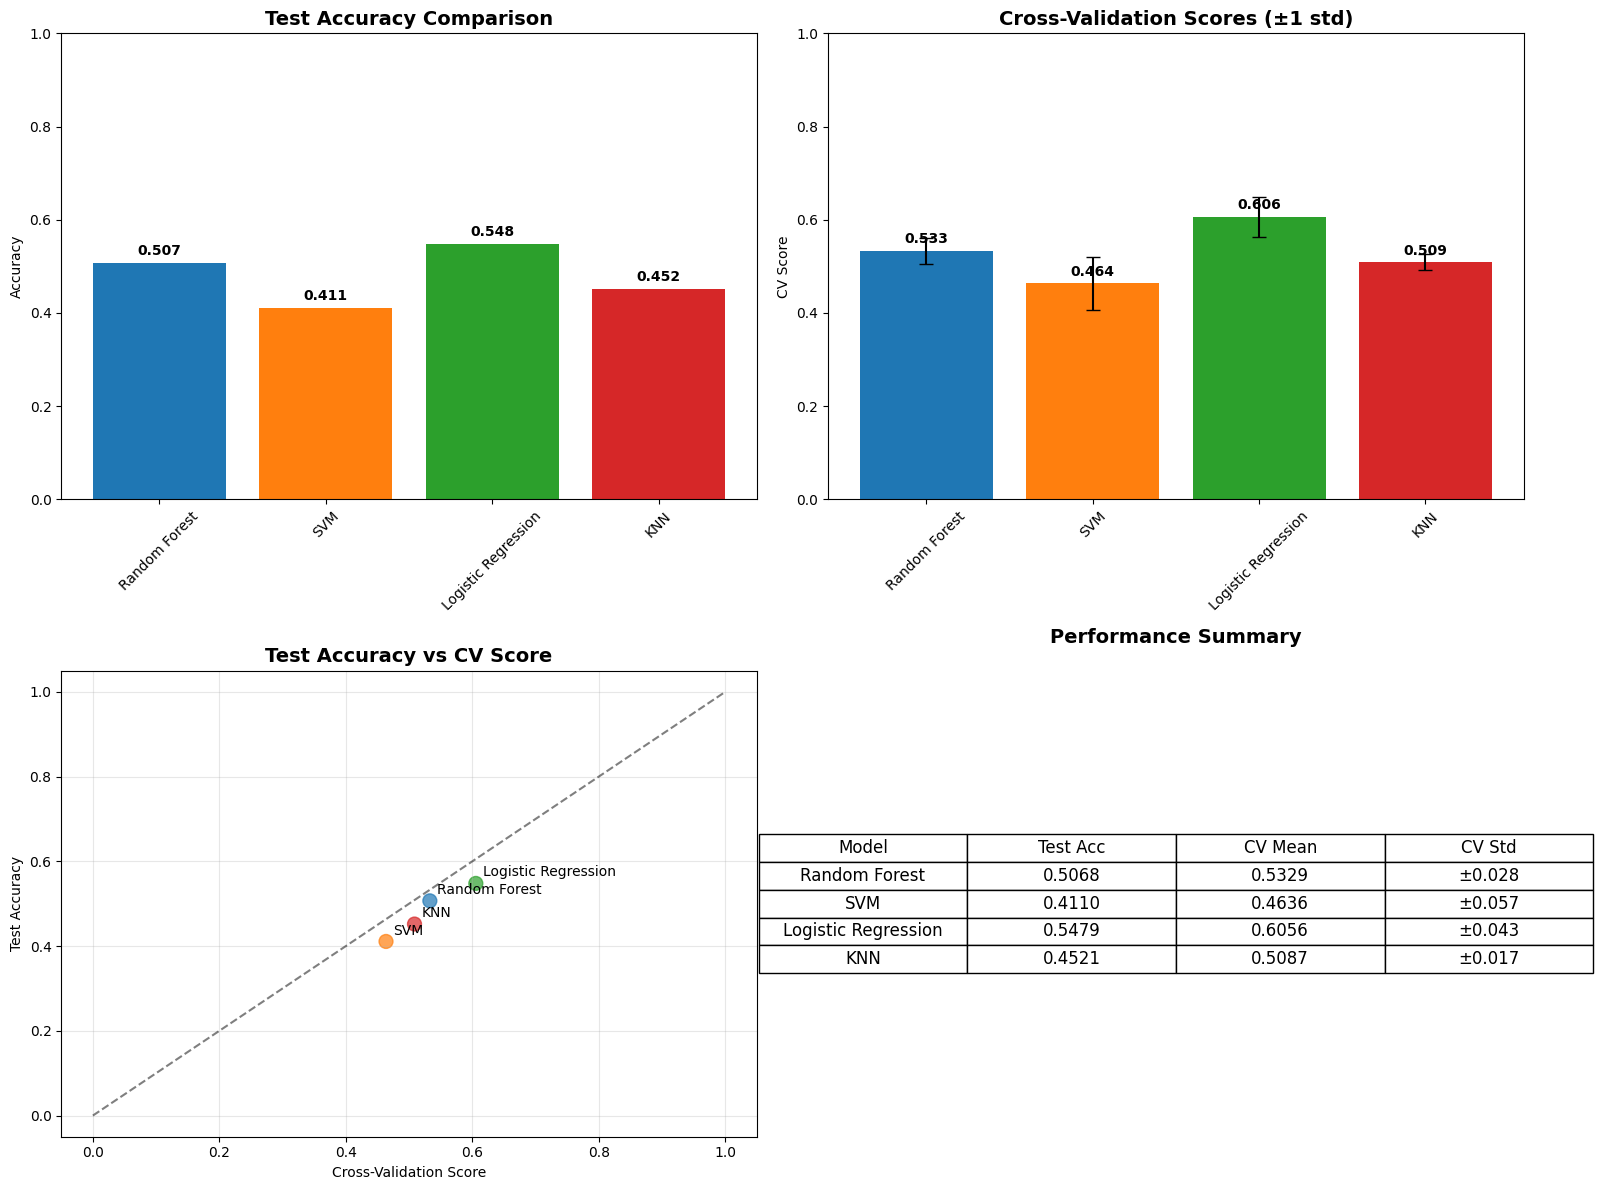


Generating enhanced confusion matrices...


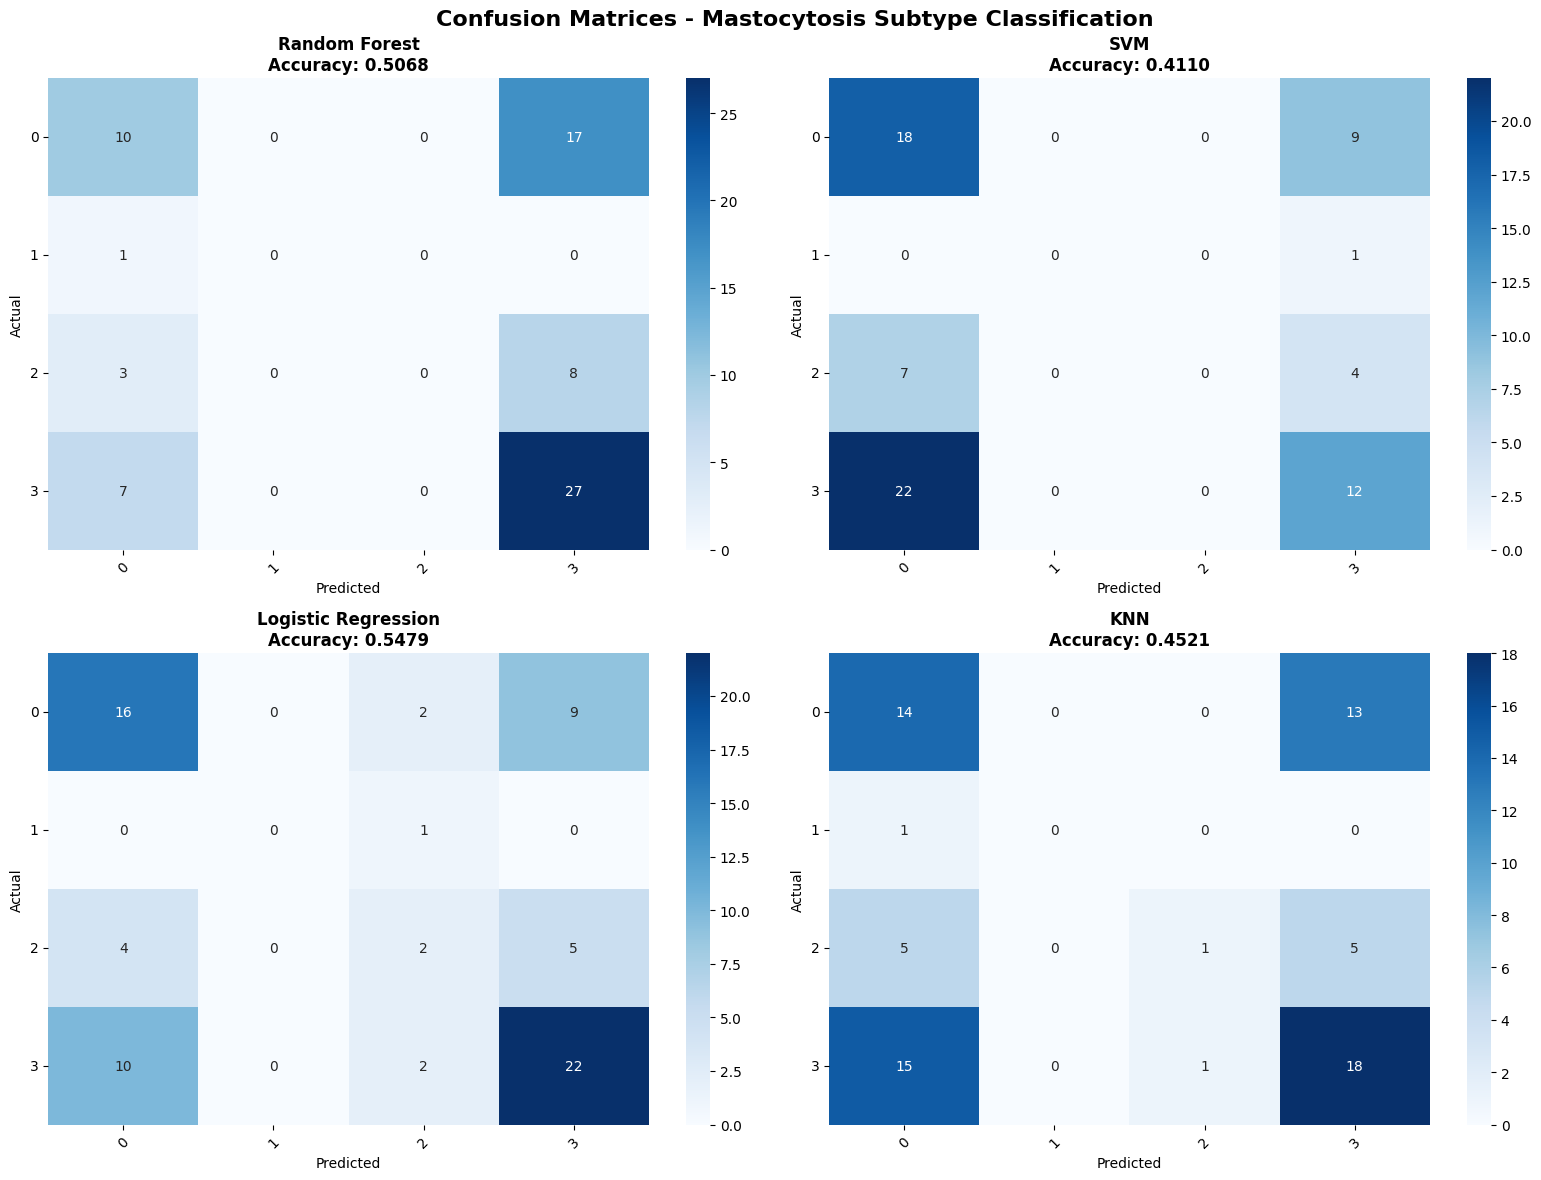


Generating feature importance analysis...


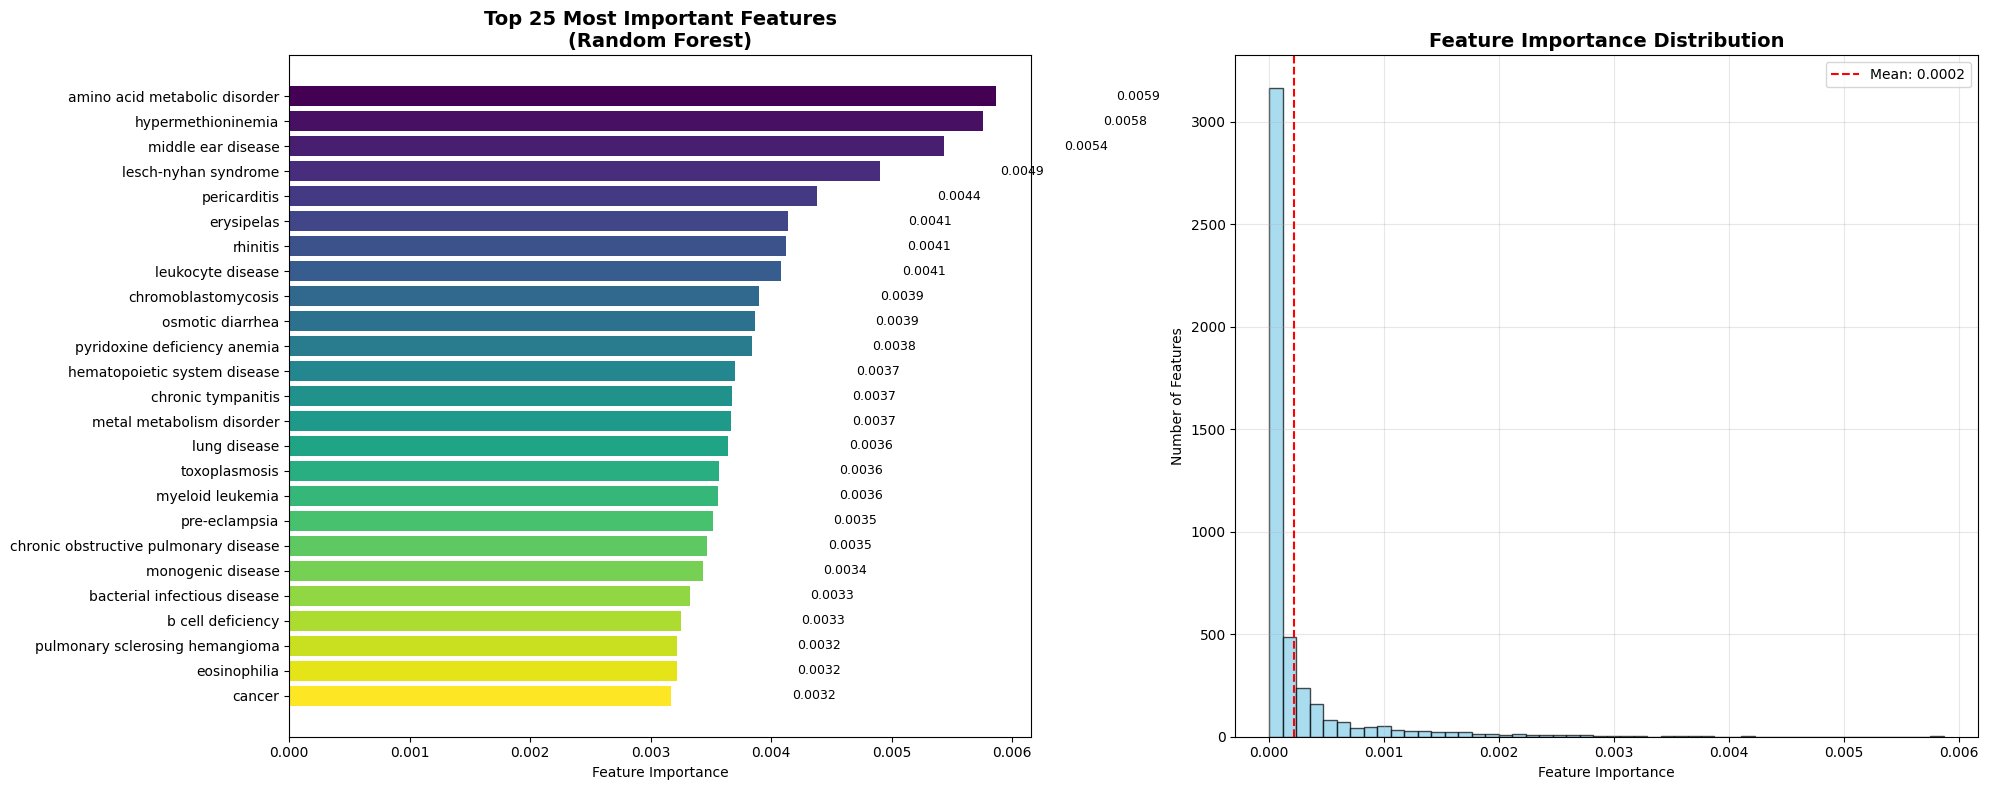


TOP 25 MOST IMPORTANT FEATURES (RANDOM FOREST)
 1. amino acid metabolic disorder            0.005866
 2. hypermethioninemia                       0.005756
 3. middle ear disease                       0.005434
 4. lesch-nyhan syndrome                     0.004903
 5. pericarditis                             0.004379
 6. erysipelas                               0.004140
 7. rhinitis                                 0.004125
 8. leukocyte disease                        0.004083
 9. chromoblastomycosis                      0.003902
10. osmotic diarrhea                         0.003866
11. pyridoxine deficiency anemia             0.003838
12. hematopoietic system disease             0.003703
13. chronic tympanitis                       0.003676
14. metal metabolism disorder                0.003668
15. lung disease                             0.003643
16. toxoplasmosis                            0.003564
17. myeloid leukemia                         0.003561
18. pre-eclampsia                 

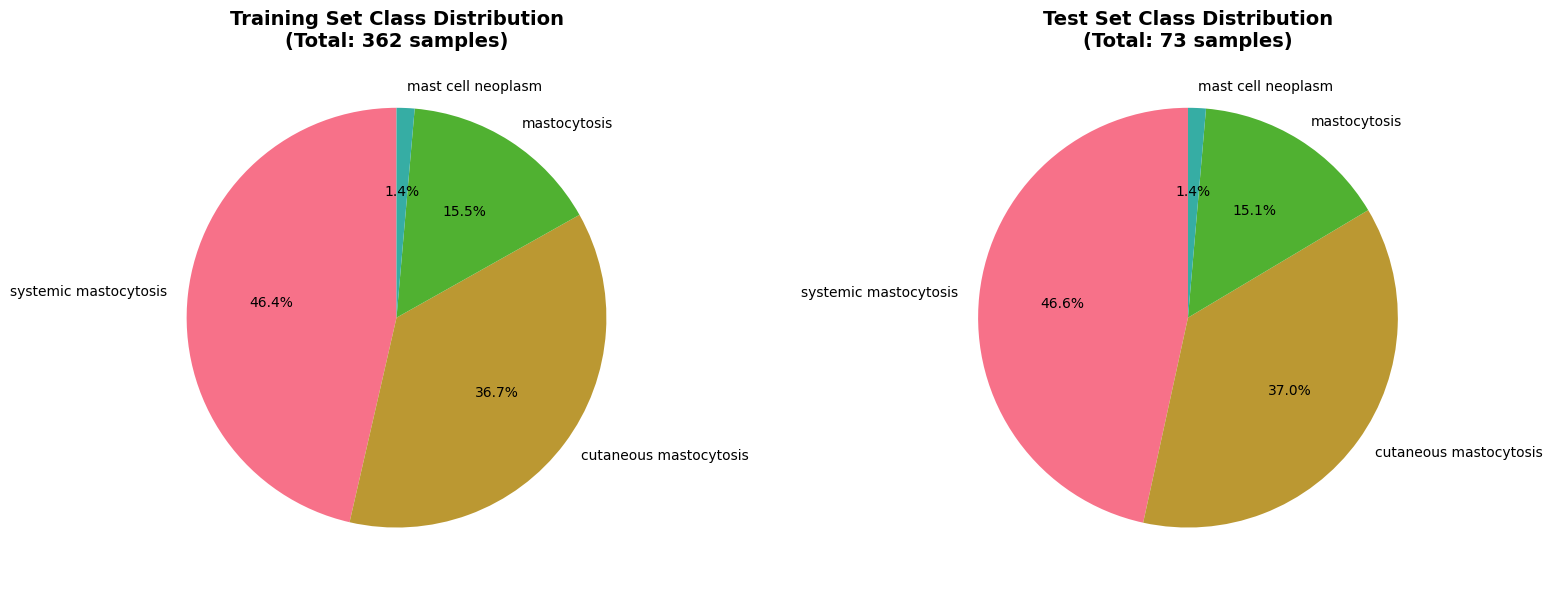


CLASS DISTRIBUTION ANALYSIS
Training set:
  systemic mastocytosis: 168 (46.4%)
  cutaneous mastocytosis: 133 (36.7%)
  mastocytosis: 56 (15.5%)
  mast cell neoplasm: 5 (1.4%)

Test set:
  systemic mastocytosis: 34 (46.6%)
  cutaneous mastocytosis: 27 (37.0%)
  mastocytosis: 11 (15.1%)
  mast cell neoplasm: 1 (1.4%)

Generating misclassification analysis...


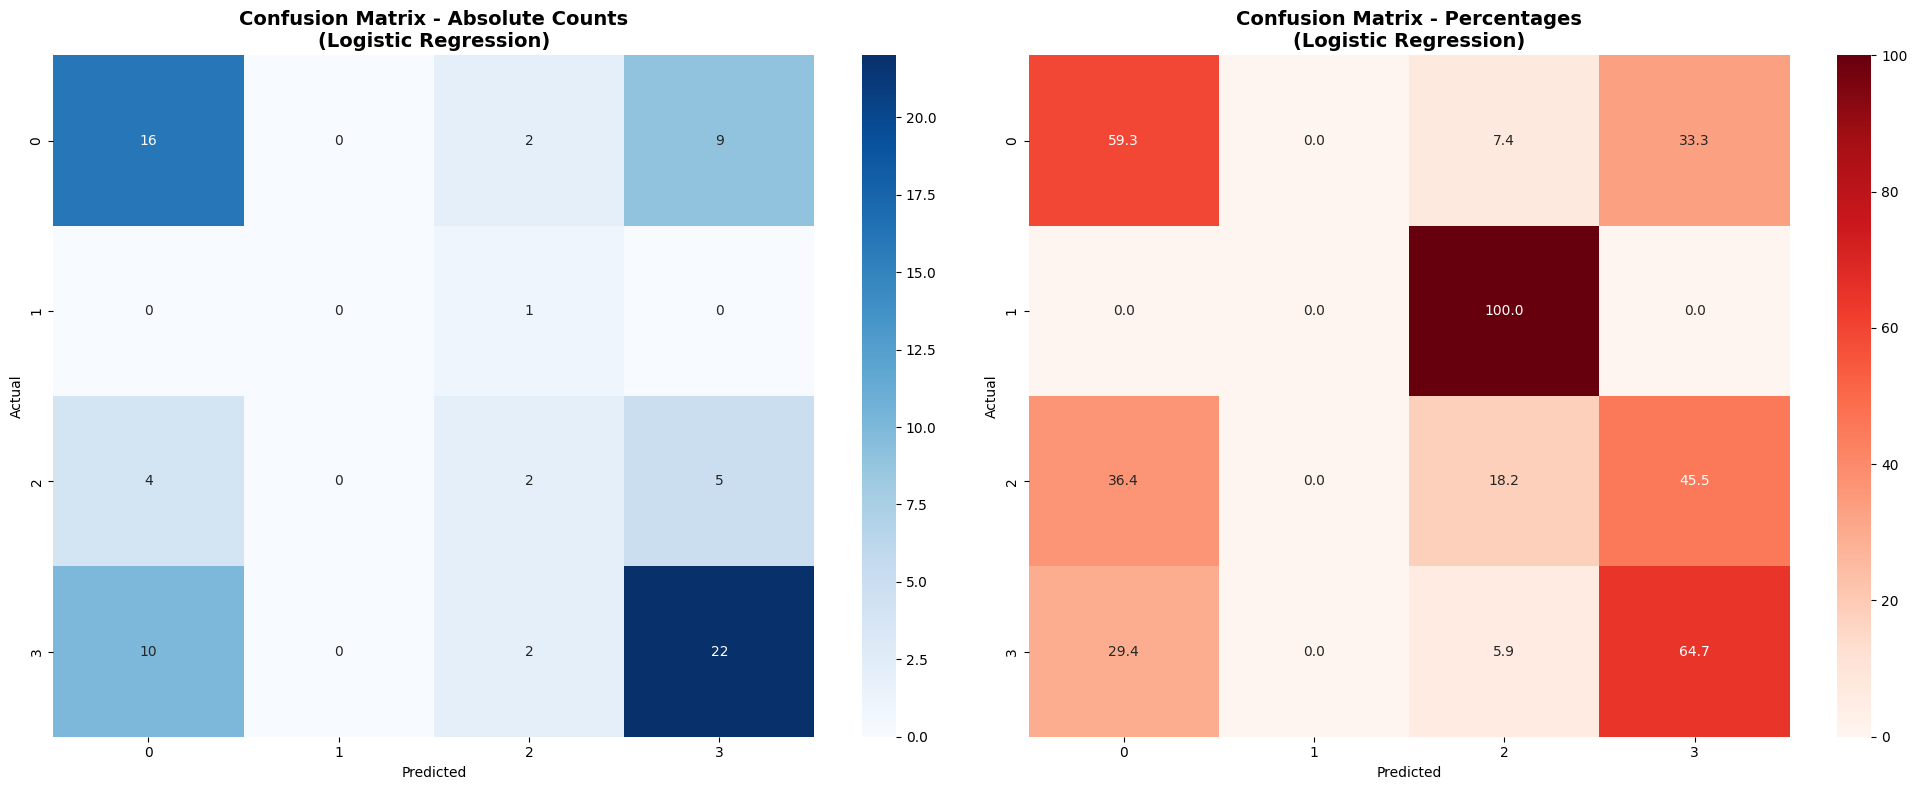


MISCLASSIFICATION PATTERNS
cutaneous mastocytosis → mastocytosis: 2 cases
cutaneous mastocytosis → systemic mastocytosis: 9 cases
mast cell neoplasm → mastocytosis: 1 cases
mastocytosis → cutaneous mastocytosis: 4 cases
mastocytosis → systemic mastocytosis: 5 cases
systemic mastocytosis → cutaneous mastocytosis: 10 cases
systemic mastocytosis → mastocytosis: 2 cases

ALL VISUALIZATIONS COMPLETE!
Generated plots:
• Model performance comparison
• Enhanced confusion matrices
• Feature importance analysis
• Class distribution analysis
• Detailed misclassification analysis


In [22]:
print("\nGenerating model comparison plots...")
plot_model_comparison(model_results)

print("\nGenerating enhanced confusion matrices...")
plot_confusion_matrices_enhanced(model_results, y_test_mc, "Mastocytosis Subtype Classification")

print("\nGenerating feature importance analysis...")
plot_feature_importance_enhanced(model_results, X_train_mc, top_n=25)

print("\nGenerating class distribution analysis...")
plot_class_distribution_analysis(y_test_mc, y_multiclass)

print("\nGenerating misclassification analysis...")
plot_detailed_misclassification_analysis(model_results, y_test_mc)

print("\nALL VISUALIZATIONS COMPLETE!")
print("Generated plots:")
print("• Model performance comparison")
print("• Enhanced confusion matrices")
print("• Feature importance analysis")
print("• Class distribution analysis")
print("• Detailed misclassification analysis")

In [34]:
def prepare_mastocytosis_data(df):
    mastocytosis_mask = df[mastocytosis_columns].abs().max(axis=1) > 0
    mastocytosis_genes = df[mastocytosis_mask].copy()
    y_multiclass = mastocytosis_genes[mastocytosis_columns].abs().idxmax(axis=1)
    feature_columns = [col for col in df.columns if col not in mastocytosis_columns + ['#.1', 'Disease']]
    X = mastocytosis_genes[feature_columns]
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)
    return X, y_multiclass

In [35]:
class AttentionClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=256, attention_dim=128):
        super(AttentionClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        self.num_classes = num_classes
        self.feature_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.feature_attention = nn.Sequential(
            nn.Linear(input_dim, attention_dim),
            nn.Tanh(),
            nn.Linear(attention_dim, input_dim),
            nn.Softmax(dim=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        feature_attention_weights = self.feature_attention(x)
        attended_input = x * feature_attention_weights
        encoded_features = self.feature_encoder(attended_input)
        output = self.classifier(encoded_features)
        return output, feature_attention_weights

In [36]:
def train_attention_model(X_train, y_train, X_test, y_test, num_epochs=150, batch_size=16, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train_encoded).to(device)
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_test_tensor = torch.LongTensor(y_test_encoded).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    input_dim = X_train.shape[1]
    num_classes = len(label_encoder.classes_)
    model = AttentionClassifier(input_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)
    train_losses, train_accuracies = [], []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs, _ = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == batch_y).sum().item()
            total_samples += batch_y.size(0)
        avg_loss = epoch_loss / len(train_loader)
        accuracy = correct_predictions / total_samples
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        scheduler.step(avg_loss)
    model.eval()
    with torch.no_grad():
        test_outputs, test_attention = model(X_test_tensor)
        _, test_predicted = torch.max(test_outputs.data, 1)
        test_accuracy = (test_predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        test_pred_labels = label_encoder.inverse_transform(test_predicted.cpu().numpy())
    return model, test_accuracy, test_pred_labels, test_attention, label_encoder, train_losses, train_accuracies

In [37]:
def get_feature_attention_importance(model, X_test, feature_names, top_k=25):
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        _, attention_weights = model(X_test_tensor)
        avg_attention = attention_weights.mean(dim=0).cpu().numpy()
        if len(feature_names) != len(avg_attention):
            raise ValueError(f"Mismatch: {len(feature_names)} features vs {len(avg_attention)} attention weights")
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'attention_weight': avg_attention
        }).sort_values('attention_weight', ascending=False)
        return feature_importance.head(top_k)

In [38]:
def plot_attention_training_curves(train_losses, train_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(train_losses, 'b-', linewidth=2)
    ax1.set_title('Training Loss (Attention Model)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax2.plot(train_accuracies, 'g-', linewidth=2)
    ax2.set_title('Training Accuracy (Attention Model)')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

In [39]:
def plot_attention_feature_importance(attention_importance, top_n=20):
    plt.figure(figsize=(12, 8))
    top_features = attention_importance.head(top_n)
    bars = plt.barh(range(len(top_features)), top_features['attention_weight'],
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_features))))
    plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
    plt.xlabel('Attention Weight')
    plt.title(f'Top {top_n} Most Important Features')
    plt.gca().invert_yaxis()
    for i, (bar, weight) in enumerate(zip(bars, top_features['attention_weight'])):
        plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{weight:.4f}', va='center', fontsize=9)
    plt.tight_layout()
    plt.show()

In [40]:
def run_complete_attention_analysis(df_clean):
    X, y_multiclass = prepare_mastocytosis_data(df_clean)
    X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
        X, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
    )
    scaler = StandardScaler()
    X_train_mc_scaled = scaler.fit_transform(X_train_mc)
    X_test_mc_scaled = scaler.transform(X_test_mc)
    attention_model, attention_accuracy, attention_predictions, attention_weights, label_encoder, train_losses, train_accs = train_attention_model(
        X_train_mc_scaled, y_train_mc, X_test_mc_scaled, y_test_mc
    )
    print(classification_report(y_test_mc, attention_predictions))
    attention_importance = get_feature_attention_importance(
        attention_model, X_test_mc_scaled, X_train_mc.columns, top_k=25
    )
    plot_attention_training_curves(train_losses, train_accs)
    plot_attention_feature_importance(attention_importance, top_n=25)
    return {
        'model': attention_model,
        'accuracy': attention_accuracy,
        'predictions': attention_predictions,
        'attention_weights': attention_weights,
        'label_encoder': label_encoder,
        'feature_importance': attention_importance,
        'train_losses': train_losses,
        'train_accuracies': train_accs,
        'X_train': X_train_mc,
        'X_test': X_test_mc,
        'y_train': y_train_mc,
        'y_test': y_test_mc,
        'scaler': scaler
    }

                        precision    recall  f1-score   support

cutaneous mastocytosis       0.35      0.70      0.47        27
    mast cell neoplasm       0.00      0.00      0.00         1
          mastocytosis       0.71      0.45      0.56        11
 systemic mastocytosis       0.50      0.18      0.26        34

              accuracy                           0.41        73
             macro avg       0.39      0.33      0.32        73
          weighted avg       0.47      0.41      0.38        73



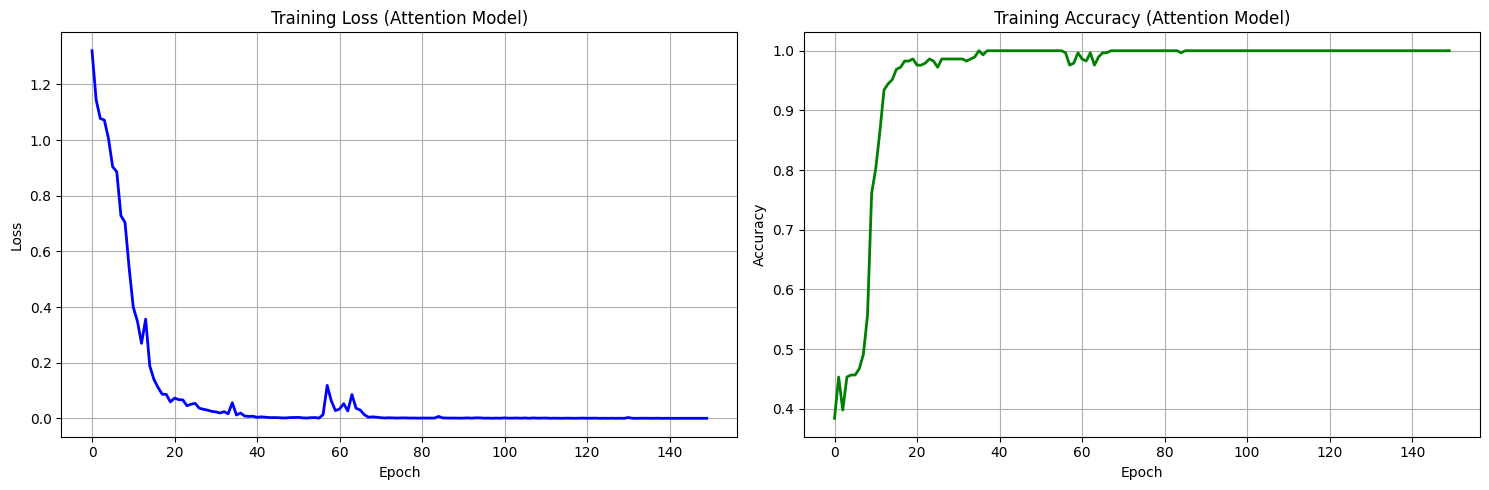

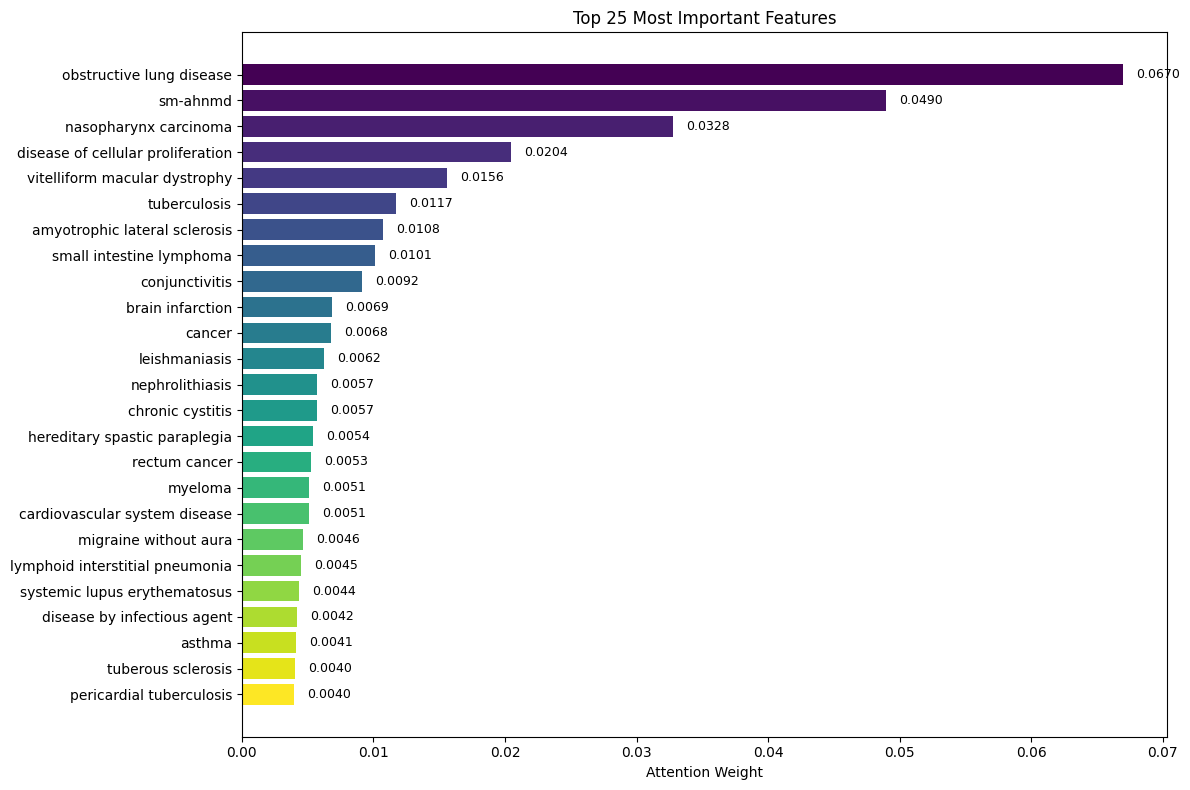

Deep Learning Accuracy: 0.4110
                                feature  attention_weight
1747           obstructive lung disease          0.066982
2802                           sm-ahnmd          0.048984
268               nasopharynx carcinoma          0.032752
1680  disease of cellular proliferation          0.020430
4165      vitelliform macular dystrophy          0.015577


In [41]:
dl_results = run_complete_attention_analysis(df_clean)
print(f"Deep Learning Accuracy: {dl_results['accuracy']:.4f}")
print(dl_results['feature_importance'].head())